# Machine Learning in Python - Project 1

s1873546

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

# packages for the different models
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor  

### 1.2 Data

In [2]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

*Include a discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up.*

*In this section you should also implement and describe any preprocessing / transformations of the features. Hint - you should not be modeling this data without transforming some of the features, e.g. modeling sale price directly is not a good idea.*

In [3]:
print("The number of missing values in the data is:", sum(sales.isnull().sum()))

The number of missing values in the data is: 0


We start our analysis by checking for missing values in the data, which is not the case. To get a general idea of what the data looks like, we plot a pairsplot of all the non-categorical features.

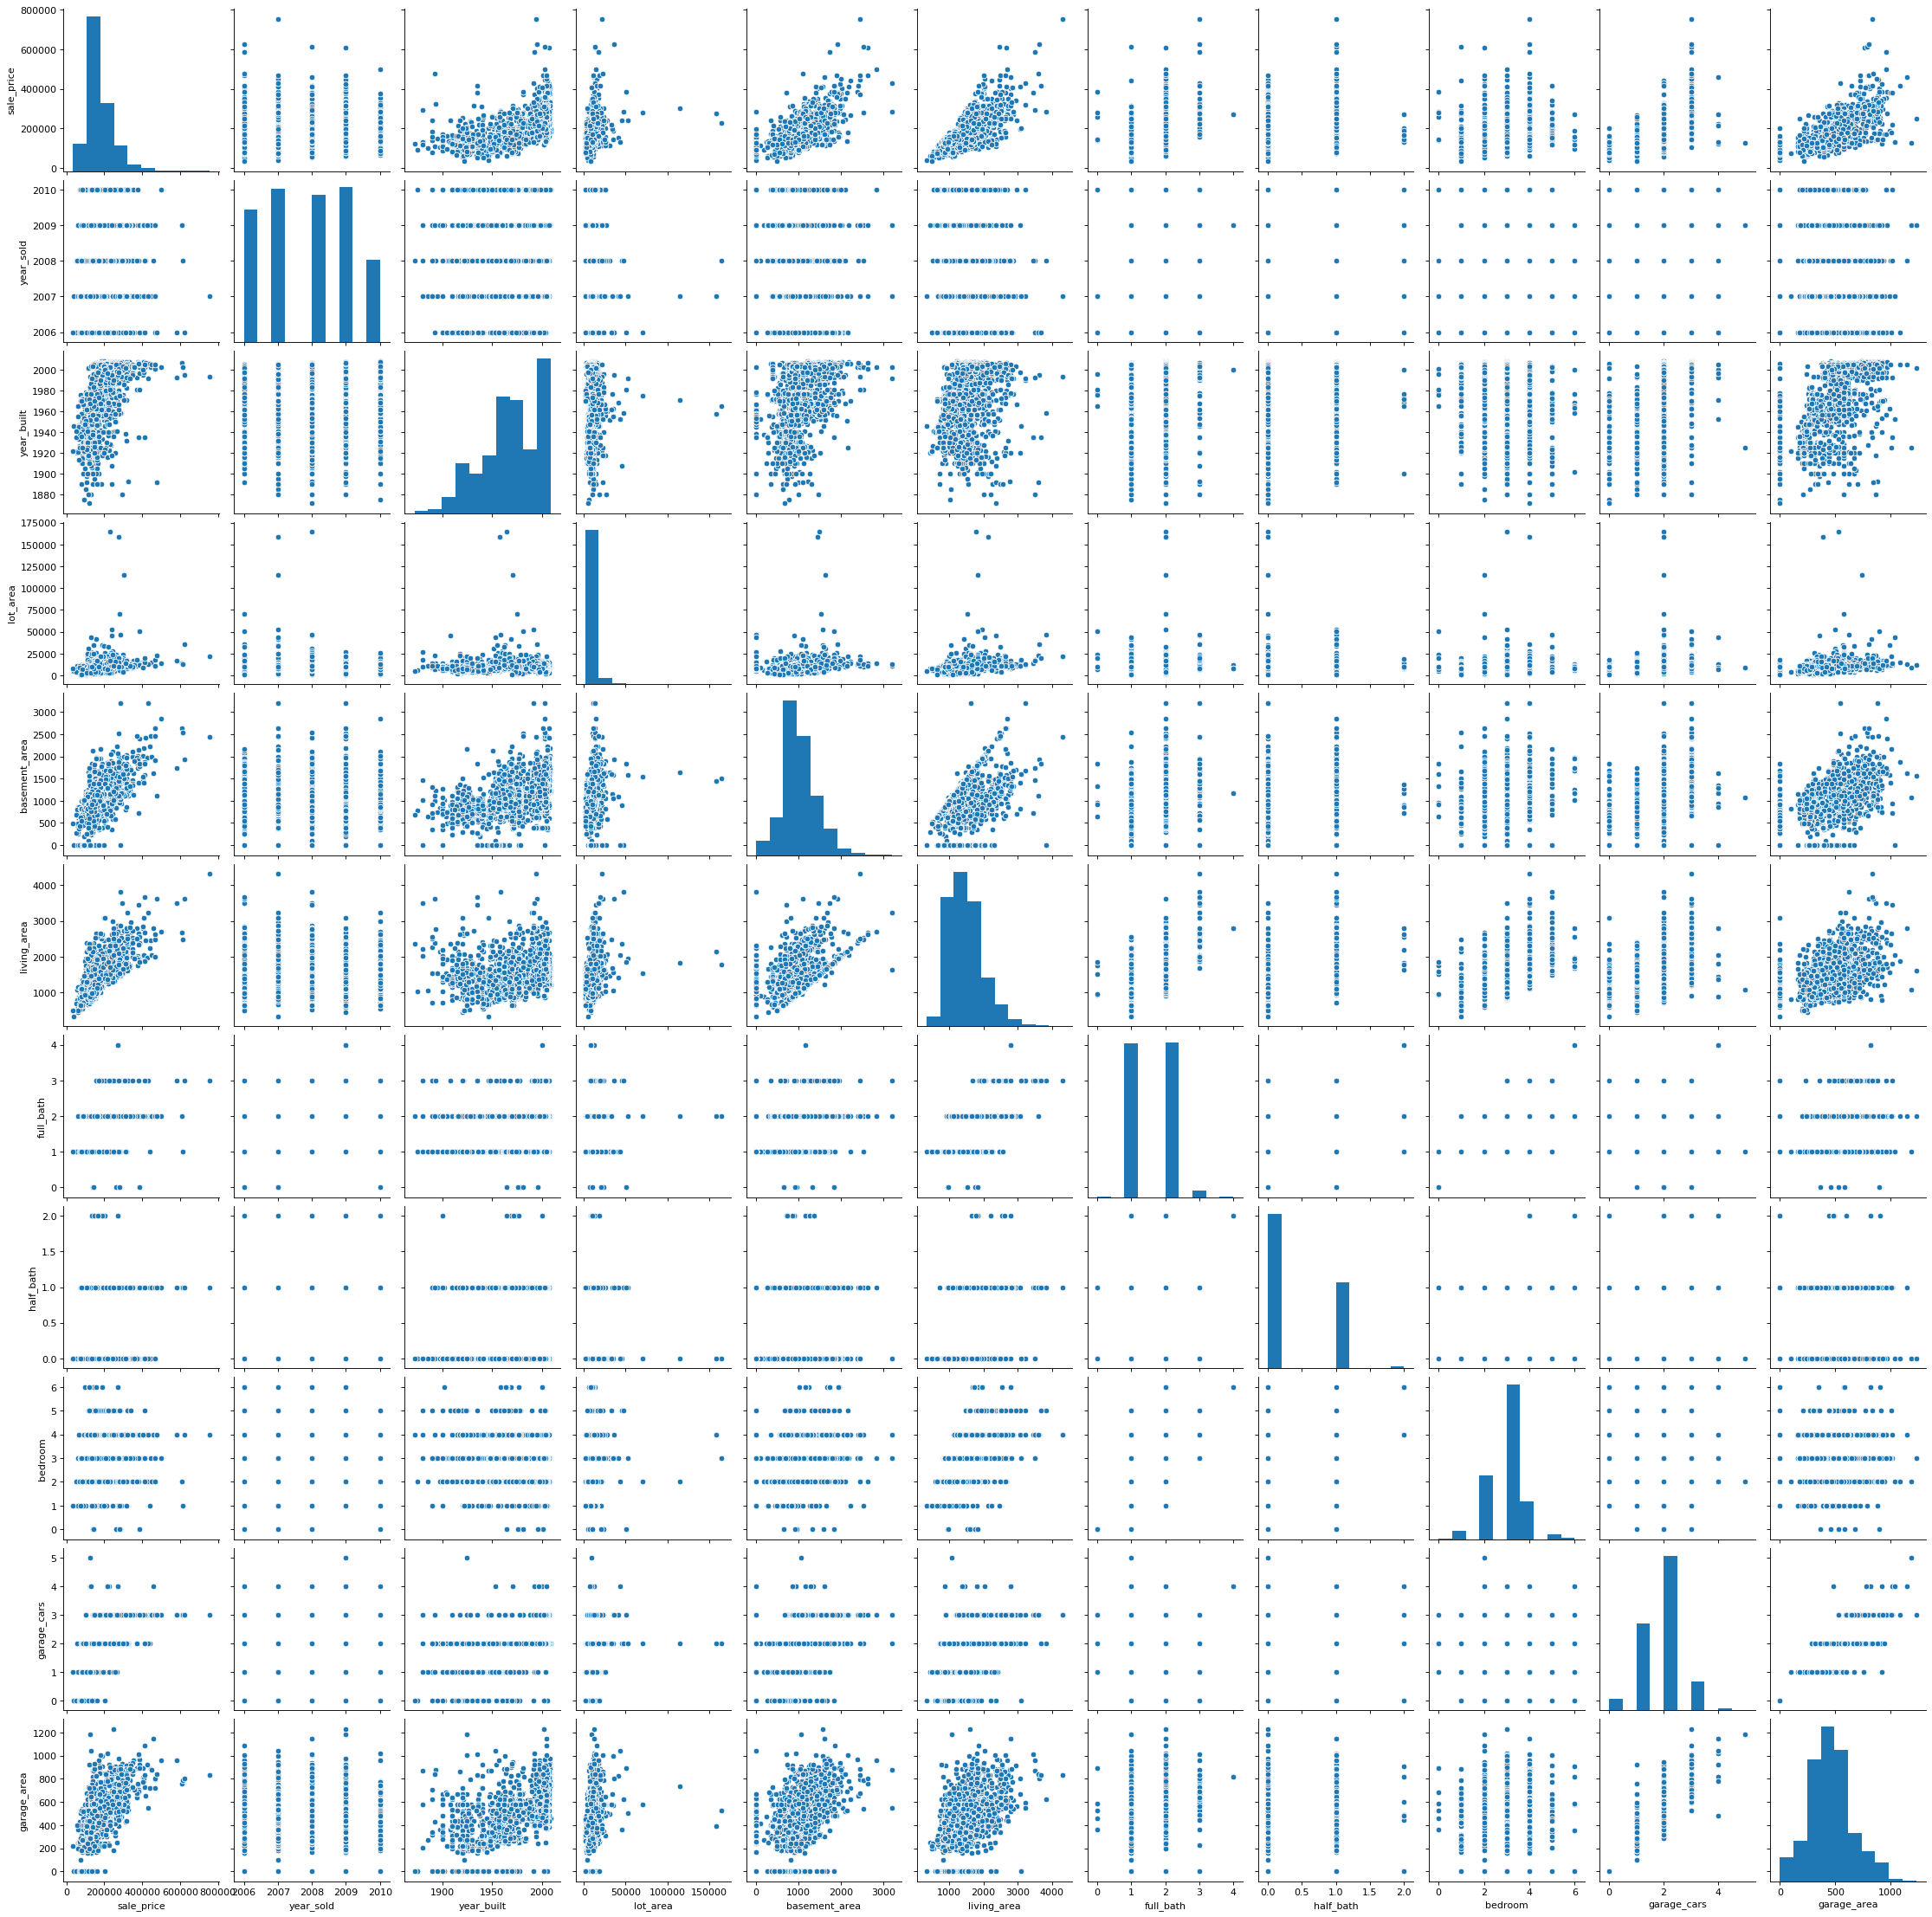

In [4]:
sns.pairplot(sales)

If we take a look at the plots on the diagonal, we see that both `sale_price` and `lot_area` are skewed, this is undesirable for using linear regression models, so we take the log of them in our model. Next, we plot a correlation matrix of the non-categorical features:

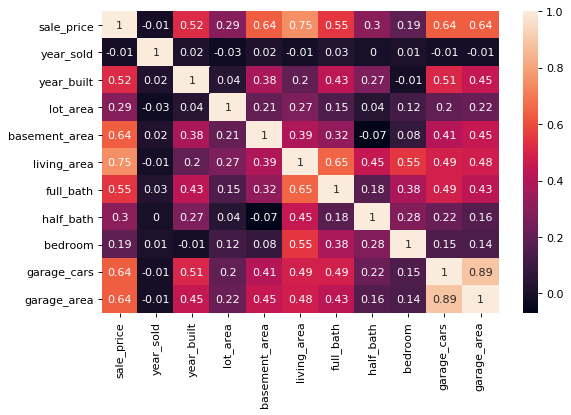

In [5]:
correlation_matrix = sales.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

What immediately draws our attention, is that `year_sold` does not correlate with any of the other features. Since we do not want to throw away this data, we decide to make a new feature `age`, which contains the age of the house and uses the information from both `year_sold` and `year_built`. Another observation is the high correlation between `garage_cars` and `garage_area`. Since it intuitively makes sense the one implies the other and that both features both give the same information, we decide to not use `garage_area` in our model. 

Next, we take a look at the categorical variable `neighborhood`:

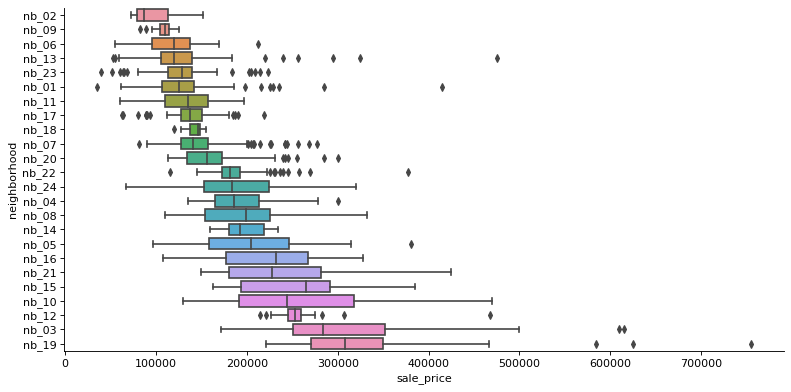

In [6]:
ranks = sales.groupby('neighborhood')['sale_price'].mean().sort_values().index
sns.catplot(x = "sale_price", y = "neighborhood", kind = "box", data = sales, aspect = 2, order=ranks)
plt.show()

If we would transform this feature into dummy variables, it would add 24 columns to our dataframe, which makes our model overly complicated. In the plot above we have ordered the different neighborhoods with regard to their means. To keep the model compact, we decide to bin the neighborhoords in 4 sets of 6. So `nhb_1` will contian the 6 neighborhoods with the lowest average sale price, `nhb_2` the ones which are bit more expensive, etc. 


We will put all the aforementioned transformations into one function which takes in the data and outputs a dataframe `X` which contains all the features that we want to model. As final steps, we take out `full_bath` because model exploration shows that this lowers the RMSE and we transform all the categorical features into dummy variables.

In [7]:
def preprocessing(sales):
    """
    Takes in dataframe sales, does the preprocessing and outputs
    the featues we want to model as dataframe X.
    """
    # Bin the neighorhoods in groups of 6
    bin1 = ['nb_02', 'nb_09', 'nb_06', 'nb_13', 'nb_23', 'nb_01']
    bin2 = ['nb_11', 'nb_17', 'nb_18', 'nb_07', 'nb_20', 'nb_22']
    bin3 = ['nb_24', 'nb_04', 'nb_08', 'nb_14', 'nb_05', 'nb_16']
    bin4 = ['nb_21', 'nb_15', 'nb_10', 'nb_12', 'nb_03', 'nb_19']
    
    # Create 4 new features: neighborhood groups with an increasing mean
    sales['nbh_1'] = sales['neighborhood'].isin(bin1).astype(int)
    sales['nbh_2'] = sales['neighborhood'].isin(bin2).astype(int)
    sales['nbh_3'] = sales['neighborhood'].isin(bin3).astype(int)
    sales['nbh_4'] = sales['neighborhood'].isin(bin4).astype(int)

    # Combine year_sold and year_built into 1 column age
    sales['age'] = sales['year_sold'] - sales['year_built']
    
    # log transform sale_price and lot_area
    sales["log_sale_price"] = np.log(sales["sale_price"])
    sales["log_lot_area"] = np.log(sales["lot_area"])
    
    # Create dataframe X and drop all the features we do not want in our model
    X = sales.copy()
    X = X.drop(columns = ["sale_price", "log_sale_price", "garage_area", "year_sold", 
                          "year_built", "neighborhood", "lot_area", "full_bath"])
    
    # Transform the categorical variables into dummys
    X = pd.get_dummies(X, drop_first = True)
    
    return X

Next up, we want to apply the preprocessing to both our training data and test data. Some models require us to scale the data, which we also immediatly do.

In [20]:
# training data
X = preprocessing(sales)
y = sales.log_sale_price

# test data
X_test = preprocessing(sales_test)
y_test = sales_test.log_sale_price

# Scaling the data
# create a dataframe with both the test and the training data
X_merged = pd.concat([X, X_test])
y_merged = pd.concat([y, y_test])
S = StandardScaler().fit(X_merged)

X_scaled = S.transform(X)
X_test_scaled = S.transform(X_test)

Finally, we want to have a final look at the correlation matrix of our selected features:

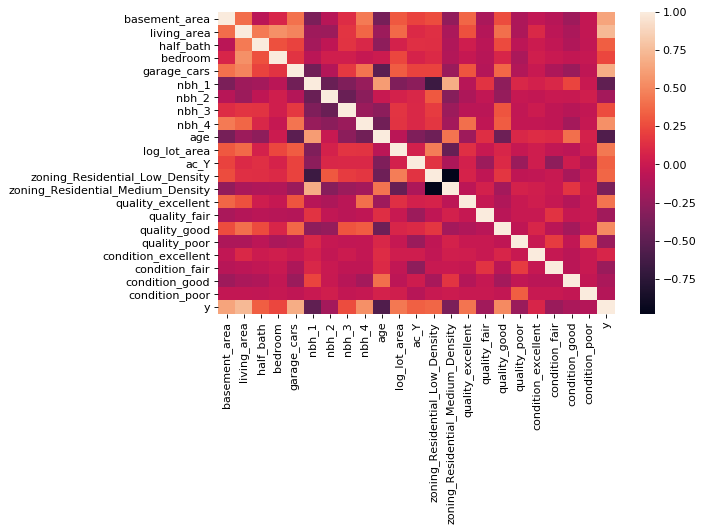

In [9]:
# create a dataframe from X and include y as a column
X_and_y = X.copy()
X_and_y['y'] = y
correlation_matrix = X_and_y.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix)
plt.show()

When we compare this matrix to the matrix we had before the preprocessing, we see that thare are now no features which stand out because of correlation which is (very close to) 0 or 1. Only 2 of the `zoning` dummy variables are very uncorrelated, but this is inevitable (and intiuitively obvious) and does not pose a problem.

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. Additional code for these models shoulds be included in a supplemental materials notebook or script. What this section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.*

After fitting multiple models we arrive at the following results:

| Model            | Test data RMSE |
| ---------------- |:--------------:| 
| Linear Regression| 0.11211|
| Regression Trees | 0.15789|
| Ridge Regression | 0.11213| 
| Kernel Ridge Regression | 11.7530| 
| Lasso Regression | 0.11273| 

We start by noticing that ploynomial features are not used. If we take a look again at the pairsplot of all the data above, we see that there are no immediate non-linear relationships between any of the features and our response variable. Therefore, polynomial features does not seem to add anything on top of e.g. linear regression.

Looking at the test RMSE's above, we see that ridge regression has the second lowest RMSE after linear regression. SInce Ridge regression is less prone to overfitting and the RMSE is only very slightly higher, we will be using Ridge. Lasso regression with a gridsearch ended up with a vallue for $\alpha$ similar to the smallest value to our grid search, and hence it has selected the model closest to a linear regression model. Kernel Ridge keeps overfitting the training data, independent of which kernel we use (tried: `rbf` and `sigmoid`), so we stick with the "normal" Ridge model.

Below you will find the implementation of the Ridge model:

In [10]:
# Start with 2 helper functions
def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of the log-transformed and non-log-transformed y
    of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    true_rmse = mean_squared_error(np.exp(y), np.exp(y_hat), squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='x', y='y', color="grey", data =  pd.DataFrame(data={'x': [min(y),max(y)], 'y': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse, true_rmse

def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

Implementation of the Ridge regresssion model including `RidgeCV` tuning:

In [11]:
r_cv = RidgeCV(
    alphas = np.linspace(0.1, 20, num=200), # RidgeCV does not allow alpha=0 for some reason
    scoring = "neg_mean_squared_error"
).fit(X_scaled, y)

# model evaluation for training set
rmse_ridge = model_fit(r_cv, X_scaled, y, plot=False)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_ridge[0]))
print("The optimal alpha is", round(r_cv.alpha_, 1))
print("\n")

# model evaluation for testing set

rmse_test_ridge = model_fit(r_cv, X_test_scaled, y_test, plot = False)
    
print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_test_ridge[0]))

The model performance for training set
--------------------------------------
RMSE is 0.11124306072835116
The optimal alpha is 12.0


The model performance for testing set
--------------------------------------
RMSE is 0.11213073528659062


As explained in workshop 5, it is desirable to scale the features when using Ridge regression. This has been done in part 1 of this asignment. In order to find the value for $\alpha$, we use cross validation and find that the optimal value for our model is 12. 

When we look into the theory, we know that if $N$ is not much larger than the dimension of the feature space ($d$), there there can be a lot of variability in the least squares fit, resulting in overfitting and consequently poorprediction. Regularization is  an  approach  to  overcome  this by shrinking the  estimated  weights where Ridge regression is a regularization technique. Since in our training data $N=1584$ and $d=22$ and in our test data $N=350$, so $N$ is not much, much larger than $d$, the regularization techniques should do slightly better than the linear methods.

## 4. Discussion


*In this section you should provide a general overview of your final model and its performance. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant. The target audience for this should be someone who is familiar with the basics of real estate and mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

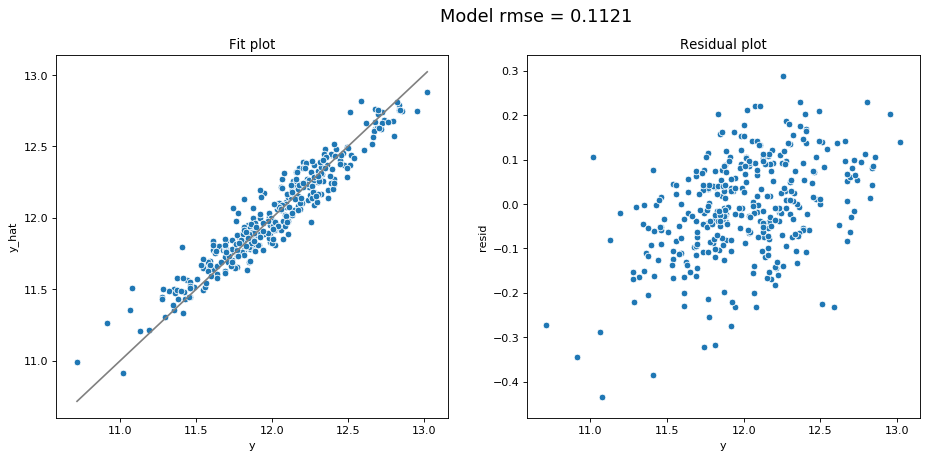

In [13]:
res = model_fit(r_cv, X_test_scaled, y_test, plot=True)

As we see in the fit plot, the data is neatly estimated by the straight line represnting the model. In the residual plot we see that the residuals are small and that the datapoints are equally distributed over the negative and positive values on the y-axis. 

Let us now have a look at the model itself and the coefficients corresponding to the different variables:

In [14]:
coeffs = get_coefs(r_cv)[1:]
params = X.columns.values

betas = pd.DataFrame([params, coeffs]).transpose()
betas.columns = ["parameter", "coefficient"]
betas.sort_values("coefficient")

,parameter,coefficient
9,age,-0.0736164
3,bedroom,-0.0297584
19,condition_fair,-0.024691
5,nbh_1,-0.0236316
17,quality_poor,-0.0213286
21,condition_poor,-0.0154065
15,quality_fair,-0.013285
6,nbh_2,-0.00674829
2,half_bath,0.00794968
7,nbh_3,0.00956933


**Features that positively impact the sale price**

The living area impacts the sale price the most and we notice that every feature that indicates an area is a very good indicator for out sale price. A house of good quality and condition, which is positioned in a spacious environment is expected to have a higher sale price. Room for a car, the number of half-baths and a neighborhood with more expensive houses also positively impact the sale price.

**Features that negatively impact the sale price**

The older the house, the lower the predicted sale price. A surprise in our model is that a higher number of bedrooms negatively influences the sale price. A bad condition and quality of the house mildly influence the sale price and when the surrounding houses in the neighborhood have a lower sale price, this negatively influences the sale price.

Finally a look at how far off our prediction is, when fitting the model to the test data:

In [19]:
print("The prediction is off by", int(rmse_test_ridge[1]), "dollars.")

The prediction is off by 20237 dollars.


## 5. Model Validation

*We have provided a third csv file called `sales_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `sales_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (350 additional house sales not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of predicting house prices. For example, buyers and sellers are likely to care if the prediction is off by `$20,000` but are less likely to care if it is off by `$500`.*

In [16]:
sales_holdout = pd.read_csv("sales_holdout.csv")

# Adjust this code as necessary to preprocess the holdout data
X_holdout = preprocessing(sales_holdout)
y_holdout = np.log(sales_holdout.sale_price)

In [17]:
# Scale the data because we are using Ridge regression
X_final = pd.concat([X_merged, X_holdout])
S = StandardScaler().fit(X_final)
X_holdout_scaled = S.transform(X_holdout)
X_merged_scaled = S.transform(X_merged)

# The final model
r_cv_final = RidgeCV(
    alphas = np.linspace(0.1, 20, num=200),
    scoring = "neg_mean_squared_error"
).fit(X_merged_scaled, y_merged)

In [24]:
# Use the model_fit function to get the RMSE of the final model

print("The prediction is off by", round(model_fit(r_cv_final, X_holdout_scaled, y_holdout, plot = False)[1], 2), "dollar")

The prediction is off by 19922.85 dollar


We see that the prediction is close to the `$20,000` dollar, which buyers and sellers would likely mind. However, having fitted a lot of different models and features, this is the best we can do with the available data. The error is about 10 percent of the average sale price in our dataset. If we perform a quick search on Google we fine that buyers generally negotiate about 10 percent of the asking price, so we could argue that this magnitude of uncertainty in the price is something that is always involved in the selling and buing of a house.